# 0. Setup

In [ ]:
! pip install transformers &> /dev/null

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import transformers

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output

import pandas as pd
import numpy as np

from google.colab import drive
import os

import time
import pdb

import copy

In [ ]:
drive.mount("/content/drive/")
os.chdir("/content/drive/My Drive/CIS530/CIS 530 project/")

Mounted at /content/drive/


# 1. Load Data

In [ ]:
Xtrain, Xdev, Xtest = pd.read_csv("implicit_hate_train.csv"), pd.read_csv("implicit_hate_dev.csv"), pd.read_csv("implicit_hate_test.csv")
Xtrain, Xdev, Xtest = Xtrain.sample(frac=1).drop("Unnamed: 0", axis = 1), Xdev.sample(frac=1).drop("Unnamed: 0", axis = 1), Xtest.sample(frac=1).drop("Unnamed: 0", axis = 1)

In [ ]:
Xtrain.head()

,post,class,implicit_class
4658,disgraceful. embarrassing. please have all inc...,implicit_hate,threatening
10968,rt proud to live in a country where an undocu...,not_hate,NaN
6986,first celebrated people possibly losing healtt...,not_hate,NaN
10605,hate is hate but there a small amount of white...,not_hate,NaN
11638,more old white people please,not_hate,NaN


In [ ]:
Xtrain["class"].value_counts()

not_hate         10633
implicit_hate     4932
explicit_hate      871
Name: class, dtype: int64

### Balance Task 1 Train Dataset

In [ ]:
_min = min(Xtrain["class"].value_counts()) # get class with the least number of examples

df1 = Xtrain[Xtrain["class"] == "not_hate"][:_min]
df2 = Xtrain[Xtrain["class"] == "implicit_hate"][:_min]
df3 = Xtrain[Xtrain["class"] == "explicit_hate"][:_min]

Xtrain1 = pd.concat([df1, df2, df3]).sample(frac=1)

In [ ]:
Xtrain1["class"].value_counts()

implicit_hate    871
not_hate         871
explicit_hate    871
Name: class, dtype: int64

### Balance Task 2 Train Dataset

In [ ]:
vc = Xtrain["implicit_class"].value_counts()

cols = vc.index
_min = min(vc)

to_concat = []

for col in cols:
  to_concat.append(Xtrain[Xtrain["implicit_class"] == col][:_min])

Xtrain2 = pd.concat(to_concat).sample(frac=1)

In [ ]:
Xtrain2["implicit_class"].value_counts()

threatening        532
stereotypical      532
incitement         532
white_grievance    532
inferiority        532
irony              532
Name: implicit_class, dtype: int64

### Balance Task 1 Dev Dataset

In [ ]:
_min = min(Xdev["class"].value_counts()) # get class with the least number of examples

df1 = Xdev[Xdev["class"] == "not_hate"][:_min]
df2 = Xdev[Xdev["class"] == "implicit_hate"][:_min]
df3 = Xdev[Xdev["class"] == "explicit_hate"][:_min]

Xdev1 = pd.concat([df1, df2, df3]).sample(frac=1)

In [ ]:
Xdev1["class"].value_counts()

not_hate         109
implicit_hate    109
explicit_hate    109
Name: class, dtype: int64

### Balance Task 2 Dev Dataset

In [ ]:
vc = Xdev["implicit_class"].value_counts()

cols = vc.index
_min = min(vc)

to_concat = []

for col in cols:
  to_concat.append(Xdev[Xdev["implicit_class"] == col][:_min])

Xdev2 = pd.concat(to_concat).sample(frac=1)

In [ ]:
Xdev2["implicit_class"].value_counts()

incitement         67
threatening        67
inferiority        67
stereotypical      67
white_grievance    67
irony              67
Name: implicit_class, dtype: int64

In [ ]:
ytrain, ytrain_implicit = pd.get_dummies(Xtrain1["class"]), pd.get_dummies(Xtrain2["implicit_class"])
ydev, ydev_implicit = pd.get_dummies(Xdev1["class"]), pd.get_dummies(Xdev2["implicit_class"])
ytest, ytest_implicit = pd.get_dummies(Xtest["class"]), pd.get_dummies(Xtest["implicit_class"])

In [ ]:
ydev.head(250)

,explicit_hate,implicit_hate,not_hate
1739,0,0,1
87,0,1,0
1885,0,0,1
449,0,1,0
450,0,1,0
...,...,...,...
579,0,1,0
1151,0,0,1
221,0,1,0
1919,0,0,1


In [ ]:
ydev.describe()

,explicit_hate,implicit_hate,not_hate
count,327.000000,327.000000,327.000000
mean,0.333333,0.333333,0.333333
std,0.472127,0.472127,0.472127
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


In [ ]:
ytrain_implicit.head()

,incitement,inferiority,irony,stereotypical,threatening,white_grievance
4532,0,0,0,0,1,0
1243,0,0,0,1,0,0
1574,1,0,0,0,0,0
2214,1,0,0,0,0,0
804,0,0,0,1,0,0


In [ ]:
torch.tensor(ytrain.iloc[1])

tensor([0, 1, 0], dtype=torch.uint8)

# 2. Build Datasets & Dataloaders

In [ ]:
class BertDataset(Dataset):

  def __init__(self, Xdf, Ydf, tokenizer, max_length = 100):

    super(BertDataset, self).__init__()

    self.Xdf, self.Ydf = Xdf, Ydf
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.Xdf) + len(self.Ydf)

  def __getitem__(self, index):
    ''' Get the text entry at a given index of the dataset '''

    # extract sentence i from Xdf
    text = self.Xdf.iloc[index, 0]

    # tokenize sentences
    inputs = self.tokenizer(text, None, padding = "max_length", add_special_tokens = True, return_attention_mask = True, max_length = self.max_length)

    # extract relevant data from tokenizer
    ids, token_type_ids, mask = inputs["input_ids"], inputs["token_type_ids"], inputs["attention_mask"]

    return {
          'ids': torch.tensor(ids, dtype=torch.long)[:self.max_length],
          'mask': torch.tensor(mask, dtype=torch.long)[:self.max_length],
          'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)[:self.max_length],
          'target': torch.tensor(self.Ydf.iloc[index])
    }

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased") # get bert-base-uncased tokenizer

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
batch_size = 10

In [ ]:
# build datasets & dataloaders

dataloaders = []
for Xdf, Ydf in zip([Xtrain1, Xtrain2, Xdev1, Xdev2, Xtest, Xtest],[ytrain, ytrain_implicit, ydev, ydev_implicit, ytest, ytest_implicit]):
  dataloaders.append(DataLoader(BertDataset(Xdf, Ydf, tokenizer), batch_size = batch_size))
train_dl, train_dl_implicit, dev_dl, dev_dl_implicit, test_dl, test_dl_implicit = tuple(dataloaders)

# 3. Define BERT

In [ ]:
class BERT(nn.Module):

  def __init__(self, task = 1):
    super(BERT, self).__init__()

    # get pretrained BERT from transformers
    self.model = transformers.BertModel.from_pretrained("bert-base-uncased")

    # get output_size based on clasification task being performed
    # task 1 = three class model
    # task 2 = six class model
    if task == 1: output_size = 3
    else: output_size = 6

    # define output layer architecture
    self.hidden = nn.Linear(768, 768)
    self.out = nn.Linear(768, output_size)

    # activations
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, ids, mask, token_type_ids):
    
    # BERT
    _, x = self.model(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict = False)

    # Output layers
    x = self.hidden(x)
    x = self.relu(x)
    x = self.out(x)
    
    x = self.softmax(x)

    return x

# 4. Train (Finetune)

In [ ]:
def finetune(dataloader, dev_dataloader, model, criterion, optimizer, n_epochs = 20, max_iter = 100, eval_interval = 10, n_sentences = 1000, verbose = False, time_lim = 1200):

  model.train()
  best_model, best_f1 = None, 0

  acc_list, f1_list, time_list = [],[],[]
  epoch, start_time = 0, time.time()

  for epoch in range(n_epochs):
    
    f1, acc = eval(dev_dataloader, model, epoch=epoch)
    f1_list.append(f1)
    acc_list.append(acc)
    time_list.append(time.time()-start_time)

    if f1 > best_f1: best_model = copy.deepcopy(model)

    loop = enumerate(dataloader)

    for batch, data in loop:

      # unpack tokenizer data
      ids, token_type_ids, mask, label = data["ids"], data["token_type_ids"], data["mask"], data["target"]

      optimizer.zero_grad()

      # use model to make predictions
      output = model(ids = ids, mask = mask, token_type_ids = token_type_ids)
      label = label.type_as(output)

      # compute loss and backprop
      loss = criterion(output, label)

      # print training stats
      if verbose and batch % eval_interval == 0:
        print(f"Training Loss: {round(float(loss.detach()),2)}")
        print(f"Training Accuracy: {round(float(torch.mean((torch.argmax(output, dim=1) == torch.argmax(label, dim=1)).float())),2)}")
        for i, (output_x, label_x) in enumerate(zip(output.detach(), label)): 
          print([round(x,2) for x in output_x.tolist()], "=>", label_x.tolist())
          if i == 2: break
        print("")

      loss.backward()
      optimizer.step()

      if (batch+1) * dataloader.batch_size >= n_sentences: break

  f1, acc = eval(dev_dataloader, model, epoch=epoch+1)
  f1_list.append(f1)
  acc_list.append(acc)
  time_list.append(time.time()-start_time)

  plot_results(f1_list, acc_list, time_list, time_lim = time_lim, n_epochs = n_epochs)

  return best_model, acc_list, f1_list, time_list

In [ ]:
def plot_results(f1, acc, time_list, time_lim = 600, n_epochs = 10):

  # per-epoch training graph

  plt.figure()

  plt.plot([epoch for epoch in range(n_epochs+1)], f1, label = "F-Score")
  plt.plot([epoch for epoch in range(n_epochs+1)], acc, label = "Accuracy")

  plt.title(f"Training Performace, n_epochs = {n_epochs}")
  plt.xlabel("Epoch")
  plt.ylabel("Performance")
  plt.legend()

  # per-time training graph

  for i, t in enumerate(time_list):
    if t > time_lim:
      f1 = f1[:i]
      acc = acc[:i]
      time_list = time_list[:i]

  # per-time training graph

  plt.figure()

  plt.plot(time_list, f1, label = "F-Score")
  plt.plot(time_list, acc, label = "Accuracy")

  plt.title(f"Training Performace, time_lim = {time_lim}")
  plt.xlabel("Training Time")
  plt.ylabel("Performance")
  plt.legend()

# 5. Evaluate

In [ ]:
def eval(dev_dataloader, model, n_classes = 6, epoch = 0, n_sentences = 50):

  loop = enumerate(dev_dataloader)

  pred_labels, labels = [],[]

  for batch, data in loop:

    ids, token_type_ids, mask, label = data["ids"], data["token_type_ids"], data["mask"], data["target"]

    # use model to make predictions
    model.eval()
    output = model(ids = ids, mask = mask, token_type_ids = token_type_ids)
    model.train()
    label = label.type_as(output)

    # aggregate results
    pred_labels += torch.argmax(output, dim=1).detach().tolist()
    labels += torch.argmax(label, dim=1).tolist()

    if (batch+1) * dev_dataloader.batch_size >= n_sentences: break
  
  pl, l = np.array(pred_labels), np.array(labels)
  acc = np.mean(pl == l)

  # print(f"\n== EVALUATION, Epoch: {epoch} ==\n")

  # print(pred_labels[:15],"\n", labels[:15],"\n", sep = "")

  # f1_agg = 0
  # for i in range(n_classes):
    
  #   tpr = np.mean((pl == i) * (l == i))
  #   fpr = np.mean((pl == i) * (l != i))
  #   fnr = np.mean((pl != i) * (l == i))

  #   prec = tpr / (fpr + tpr)
  #   rec = tpr / (fnr + tpr)

  #   if np.isnan(prec): prec = 0
  #   if np.isnan(rec): rec = 0

  #   f1 = prec * rec / (prec + rec)
  #   if np.isnan(f1): f1 = 0
  #   f1_agg += f1

  #   print(f"Class {i}: TPR={round(tpr,2)}, FPR={round(fpr,2)}, FNR={round(fnr,2)}, Precision={round(prec,2)}, Recall={round(rec,2)}, F-Score={round(f1,2)}")

  f1 = f1_score(pl, l, average = 'macro')
  acc = accuracy_score(pl, l)

  print("\nOVERALL: ")
  print(f"F-Score: {round(f1,2)}")
  print(f"Dev Accuracy: {round(acc,2)}")
  print(f"\n== END EVAL, Epoch {epoch} ==\n")

  return f1, acc

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



== EVALUATION, Epoch: 0 ==

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 4, 1, 0, 3, 5, 4, 1, 1, 5, 0, 2, 4, 5, 0]


OVERALL: 
F-Score: 0.1
Dev Accuracy: 0.22

== END EVAL, Epoch 0 ==


== EVALUATION, Epoch: 1 ==

[5, 5, 5, 5, 5, 1, 1, 5, 5, 5, 5, 5, 5, 5, 1]
[0, 4, 1, 0, 3, 5, 4, 1, 1, 5, 0, 2, 4, 5, 0]


OVERALL: 
F-Score: 0.14
Dev Accuracy: 0.18

== END EVAL, Epoch 1 ==


== EVALUATION, Epoch: 2 ==

[5, 5, 2, 3, 5, 4, 1, 5, 5, 3, 5, 5, 5, 5, 5]
[0, 4, 1, 0, 3, 5, 4, 1, 1, 5, 0, 2, 4, 5, 0]


OVERALL: 
F-Score: 0.14
Dev Accuracy: 0.2

== END EVAL, Epoch 2 ==


== EVALUATION, Epoch: 3 ==

[5, 0, 2, 3, 0, 4, 1, 5, 5, 0, 5, 0, 0, 5, 1]
[0, 4, 1, 0, 3, 5, 4, 1, 1, 5, 0, 2, 4, 5, 0]


OVERALL: 
F-Score: 0.24
Dev Accuracy: 0.28

== END EVAL, Epoch 3 ==


== EVALUATION, Epoch: 4 ==

[5, 0, 2, 3, 0, 1, 1, 5, 5, 0, 5, 5, 0, 5, 1]
[0, 4, 1, 0, 3, 5, 4, 1, 1, 5, 0, 2, 4, 5, 0]


OVERALL: 
F-Score: 0.23
Dev Accuracy: 0.26

== END EVAL, Epoch 4 ==


== EVALUATION, Epoch: 5 ==

[5, 0, 2, 3, 

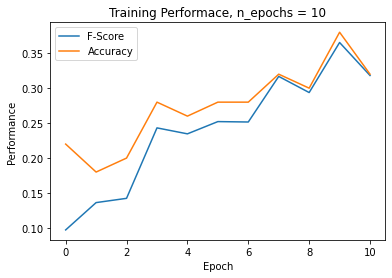

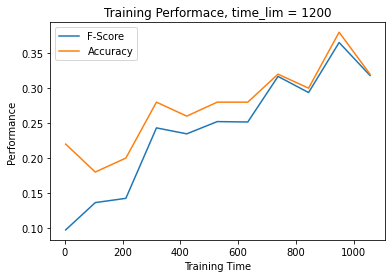

In [ ]:
## TASK 1, 0 Layers Unfrozen

task = 2
n_unfrozen = 0
model = BERT(task=task)

freeze_bound = n_unfrozen * 14 + 2
for i, param in enumerate(model.model.parameters()):
  if i > freeze_bound:   param.requires_grad = False

## Loss function & optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 2e-5)

model, acc_list, f1_list, time_list = finetune(train_dl_implicit, dev_dl_implicit, model, criterion, optimizer, n_epochs = 10, verbose = False)

In [ ]:
## TASK 1, 1 Layer Unfrozen

task = 1
n_unfrozen = 1
model1 = BERT()

freeze_bound = n_unfrozen * 14 + 2
for i, param in enumerate(model1.model.parameters()):
  if i > freeze_bound: param.requires_grad = False

## Loss function & optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model1.parameters(), lr = 2e-5)

model1, acc_list1, f1_list1, time_list1 = finetune(train_dl, dev_dl, model1, criterion, optimizer, n_epochs = 10, verbose = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



== EVALUATION, Epoch: 0 ==

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 1, 2, 1, 1, 2, 0, 0, 2, 0, 2, 2, 1, 2, 2]


OVERALL: 
F-Score: 0.14
Dev Accuracy: 0.26

== END EVAL, Epoch 0 ==



KeyboardInterrupt: ignored

In [ ]:
## TASK 1, 2 Layers Unfrozen

task = 1
n_unfrozen = 2
model2 = BERT()

freeze_bound = n_unfrozen * 14 + 2
for i, param in enumerate(model2.model.parameters()):
  if i > freeze_bound: param.requires_grad = False

## Loss function & optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr = 2e-5)

model2, acc_list2, f1_list2, time_list2 = finetune(train_dl, dev_dl, model2, criterion, optimizer, n_epochs = 10, verbose = False)

In [ ]:
## TASK 1, 4 Layers Unfrozen

task = 1
n_unfrozen = 4
model4 = BERT()

freeze_bound = n_unfrozen * 14 + 2
for i, param in enumerate(model4.model.parameters()):

  if i > freeze_bound: 
    param.requires_grad = False
    if verbose: print(i, param.shape)

## Loss function & optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model4.parameters(), lr = 2e-5)

model4, acc_list4, f1_list4, time_list4 = finetune(train_dl, dev_dl, model4, criterion, optimizer, n_epochs = 10, verbose = False)

In [ ]:
## TASK 1, 8 Layers Unfrozen

task = 1
n_unfrozen = 8
model8 = BERT()

freeze_bound = n_unfrozen * 14 + 2
for i, param in enumerate(model8.model.parameters()):

  if i > freeze_bound: 
    param.requires_grad = False
    if verbose: print(i, param.shape)

## Loss function & optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model8.parameters(), lr = 2e-5)

model8, acc_list8, f1_list8, time_list8 = finetune(train_dl, dev_dl, model8, criterion, optimizer, n_epochs = 10, verbose = False)

In [ ]:
## TASK 1, 12 Layers Unfrozen

task = 1
n_unfrozen = 12
model12_ = BERT(task = task)

## Loss function & optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model12_.parameters(), lr = 2e-5)

model12_, acc_list12, f1_list12, time_list12 = finetune(train_dl, dev_dl, model12_, criterion, optimizer, n_epochs = 4, verbose = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



== EVALUATION, Epoch: 0 ==

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 1, 2, 1, 1, 2, 0, 0, 2, 0, 2, 2, 1, 2, 2]

Class 0: TPR=0.0, FPR=0.0, FNR=0.26, Precision=0, Recall=0.0, F-Score=0
Class 1: TPR=0.38, FPR=0.62, FNR=0.0, Precision=0.38, Recall=1.0, F-Score=0.28
Class 2: TPR=0.0, FPR=0.0, FNR=0.36, Precision=0, Recall=0.0, F-Score=0


<ipython-input-75-dc187f1aa1b2>:37: RuntimeWarning: invalid value encountered in double_scalars
  prec = tpr / (fpr + tpr)
<ipython-input-75-dc187f1aa1b2>:43: RuntimeWarning: invalid value encountered in double_scalars
  f1 = prec * rec / (prec + rec)
<ipython-input-75-dc187f1aa1b2>:38: RuntimeWarning: invalid value encountered in double_scalars
  rec = tpr / (fnr + tpr)


ZeroDivisionError: ignored

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



OVERALL: 
F-Score: 0.26
Dev Accuracy: 0.34

== END EVAL, Epoch 0 ==


OVERALL: 
F-Score: 0.25
Dev Accuracy: 0.38

== END EVAL, Epoch 1 ==


OVERALL: 
F-Score: 0.57
Dev Accuracy: 0.56

== END EVAL, Epoch 2 ==


OVERALL: 
F-Score: 0.52
Dev Accuracy: 0.52

== END EVAL, Epoch 3 ==


OVERALL: 
F-Score: 0.53
Dev Accuracy: 0.58

== END EVAL, Epoch 4 ==



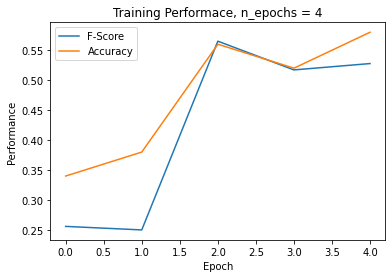

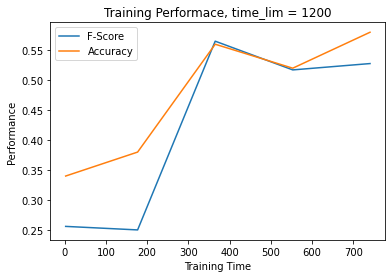

In [ ]:
## TASK 1, 12 Layers Unfrozen

task = 1
model12 = BERT(task = task)

## Loss function & optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model12.parameters(), lr = 2e-5)

model12, acc_list12, f1_list12, time_list12 = finetune(train_dl, dev_dl, model12, criterion, optimizer, n_epochs = 4, verbose = False)


== EVALUATION, Epoch: 0 ==

[1, 1, 1, 5, 5, 5, 1, 5, 1, 3, 5, 5, 1, 5, 5]
[0, 4, 1, 0, 3, 5, 4, 1, 1, 5, 0, 2, 4, 5, 0]

Class 0: TPR=0.0, FPR=0.02, FNR=0.22, Precision=0.0, Recall=0.0, F-Score=0
Class 1: TPR=0.12, FPR=0.44, FNR=0.06, Precision=0.21, Recall=0.67, F-Score=0.16
Class 2: TPR=0.0, FPR=0.0, FNR=0.1, Precision=0, Recall=0.0, F-Score=0
Class 3: TPR=0.02, FPR=0.06, FNR=0.08, Precision=0.25, Recall=0.2, F-Score=0.11
Class 4: TPR=0.0, FPR=0.0, FNR=0.24, Precision=0, Recall=0.0, F-Score=0
Class 5: TPR=0.08, FPR=0.26, FNR=0.08, Precision=0.24, Recall=0.5, F-Score=0.16

OVERALL: 
F-Score: 0.14
Dev Accuracy: 0.22

== END EVAL, Epoch 0 ==



<ipython-input-75-dc187f1aa1b2>:43: RuntimeWarning: invalid value encountered in double_scalars
  f1 = prec * rec / (prec + rec)
<ipython-input-75-dc187f1aa1b2>:37: RuntimeWarning: invalid value encountered in double_scalars
  prec = tpr / (fpr + tpr)



== EVALUATION, Epoch: 1 ==

[3, 1, 1, 5, 5, 5, 1, 5, 1, 5, 5, 5, 1, 5, 5]
[0, 4, 1, 0, 3, 5, 4, 1, 1, 5, 0, 2, 4, 5, 0]

Class 0: TPR=0.0, FPR=0.02, FNR=0.22, Precision=0.0, Recall=0.0, F-Score=0
Class 1: TPR=0.1, FPR=0.22, FNR=0.08, Precision=0.31, Recall=0.56, F-Score=0.2
Class 2: TPR=0.0, FPR=0.0, FNR=0.1, Precision=0, Recall=0.0, F-Score=0
Class 3: TPR=0.0, FPR=0.02, FNR=0.1, Precision=0.0, Recall=0.0, F-Score=0
Class 4: TPR=0.08, FPR=0.0, FNR=0.16, Precision=1.0, Recall=0.33, F-Score=0.25
Class 5: TPR=0.14, FPR=0.42, FNR=0.02, Precision=0.25, Recall=0.88, F-Score=0.19

OVERALL: 
F-Score: 0.21
Dev Accuracy: 0.32

== END EVAL, Epoch 1 ==



<ipython-input-75-dc187f1aa1b2>:43: RuntimeWarning: invalid value encountered in double_scalars
  f1 = prec * rec / (prec + rec)
<ipython-input-75-dc187f1aa1b2>:37: RuntimeWarning: invalid value encountered in double_scalars
  prec = tpr / (fpr + tpr)


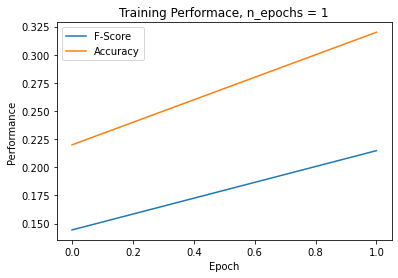

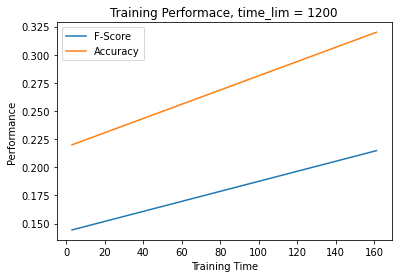

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model12.parameters(), lr = 2e-6)

model12, acc_list12, f1_list12, time_list12 = finetune(train_dl_implicit, dev_dl_implicit, model12, criterion, optimizer, n_epochs = 1, verbose = False)

explicit_hate, implicit_hate, not_hate

In [ ]:
eval(test_dl_implicit, model12, n_classes = 6, n_sentences = 500)

KeyboardInterrupt: ignored

In [ ]:
Xtrain.head(100)

,post,class,implicit_class
4658,disgraceful. embarrassing. please have all inc...,implicit_hate,threatening
10968,rt proud to live in a country where an undocu...,not_hate,NaN
6986,first celebrated people possibly losing healtt...,not_hate,NaN
10605,hate is hate but there a small amount of white...,not_hate,NaN
11638,more old white people please,not_hate,NaN
...,...,...,...
8552,attn : all white people : here's yoir eake up ...,not_hate,NaN
756,how many isis soldiers came in with them? we m...,implicit_hate,stereotypical
7441,scotus agrees to tackle religious hostility by...,not_hate,NaN
3803,"of course, americans exist merely to serve imm...",implicit_hate,inferiority


In [ ]:
tokenized_input = tokenizer("	how about a review of white trash by nancy isenburg ?")

In [ ]:
model12_(torch.tensor(tokenized_input.input_ids).unsqueeze(0), torch.tensor(tokenized_input.token_type_ids).unsqueeze(0), torch.tensor(tokenized_input.attention_mask).unsqueeze(0))

tensor([[0.3706, 0.3368, 0.2927]], grad_fn=<SoftmaxBackward0>)

In [ ]:
import sklearn

In [ ]:
def train_and_evaluate(model, training_set, evaluation_set, key, plot_confusion_matrix=True):

  inference = model.predict(evaluation_set)
  if plot_confusion_matrix:
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(evaluation_set[key], inference, xticks_rotation="vertical")
  print(f"f1 score for {key}: {get_f1_score(evaluation_set[key], inference)}")